In [43]:
def f(x, g):
    if x <= 1:
        return g(x)
    else:
        return(g(1/x))
    
def g(x):
    return x**3+x**2



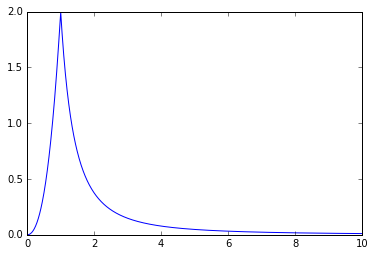

In [44]:
from matplotlib import pyplot as plt
import numpy as np

x = np.linspace(0.000001, 10, 1000)
plt.plot(x, [f(xx, g) for xx in x])

# Testing convergence of MCMC method for evidence value calculation

In [1]:
import numpy as np


In [10]:

def cposterior_full(s1, s2, Nw, N2, sum1, sum2):
    ''' Full log-posterior kernel for MCMC sampling

        Arguments:

        s1 - current value for sigma1
        s2 - current value for sigma2
        Nw - total signal size
        N2 - size of second segment
        sum1 - sum of amplitudes squared for first segment
        sum2 - sum of amplitudes squared for second segment
    '''
    
    if s1 <= 0 or s2 <= 0:
        return -1e+308
    
    # Jeffreys' prior for sigma 1
    dpriors1 = -np.log(s1)

    # Jeffreys' prior for sigma 2
    dpriors2 = -np.log(s2)

    post = dpriors1 +  dpriors2 - (Nw-N2)*np.log(s1)-N2*np.log(s2)
    post = post - sum1/(2*(s1**2)) - sum2/(2*(s2**2))

    return post


In [12]:
def mcmc(p0, mcburn, mciter, beta, N, N2, sum1, sum2):
    ''' Run MCMC

        Arguments:

        mcburn - burn-in period for chain
        mciter - number of points to sample
        p0 - posterior under H0
        beta - parameter for Laplace prior
        N - total signal size
        N2 - size of second segment
        sum1 - sum of amplitude squared for the first segment
        sum2 - sum of amplitude squared for the second segment

    '''
    
    s2cur = np.sqrt(sum2 / (N2-1))
    s1cur = np.sqrt(sum1 / (N-N2-1))

    # Standard deviations and covariance for random-walk candidates distributions
    s1var = (s1cur / 3) ** 2
    s2var = (s2cur / 3) ** 2
    cov = 0.0
    
    s2cur = abs(s2cur + np.random.normal(0, s2var))
    s1cur = abs(s1cur + np.random.normal(0, s1var))

    pcur = cposterior_full(s1cur, s2cur, N, N2, sum1, sum2)
    
    
    # Parameters for adaptive MH
    sd = (2.4*2.4)/2.0
    eps = 1e-30

    # Starting point for adaptive MH
    t0 = 500
    
    s1mean = 0.0
    s2mean = 0.0
    sums1sq = 0.0
    sums2sq = 0.0
    cov0 = 0.0
    accept = 0
    for i in range(t0):
        
        # Generate candidates
        u1 = np.random.normal(0, 1)
        s1cand = s1cur + u1*np.sqrt(s1var)
        
        if s1cand > 0:
            # Calculates full posterior
            pcand = cposterior_full(s1cand, s2cur, N, N2, sum1, sum2)

            # Acceptance ratio
            #a = Exp(pcand - pcur) * Exp(scand - scur)
            a = (pcand - pcur)

            if np.log(np.random.uniform()) < a:
                s1cur = s1cand
                pcur = pcand
                accept = accept + 1
            #endif        
        
        u2 = np.random.normal(0, 1)
        s2cand = abs(s2cur + np.sqrt(s2var)*u2)
        
        if s2cand > 0:
            # Calculates full posterior
            pcand = cposterior_full(s1cur, s2cand, N, N2, sum1, sum2)

            # Acceptance ratio
            #a = Exp(pcand - pcur) * Exp(scand - scur)
            a = (pcand - pcur)

            if np.log(np.random.uniform()) < a:
                s2cur = s2cand
                pcur = pcand
                accept = accept + 1
            #endif
        
        s1mean = s1mean + s1cur 
        s2mean = s2mean + s2cur
        cov0 = cov0 + s1cur*s2cur 
        sums1sq = sums1sq + s1cur*s1cur 
        sums2sq = sums2sq + s2cur*s2cur 
        
    #endfor
    
    assert accept > 0
    tmp = s1mean*s1mean/t0
    tmp = sums1sq - tmp
    s1var = tmp/(t0-1.0)
    tmp = s2mean*s2mean/t0
    tmp = sums2sq - tmp
    s2var = tmp/(t0-1.0)
    
    if s2var < 0 or s1var < 0:
        print(accept)
        print((smean*smean)/t0)
        print([sumssq, smean, t0])
        print(svar)
    
    cov = (1/(t0-1))*(cov0 - s1mean*s2mean/t0)
    rho = cov/(np.sqrt(s1var*s2var))
    s1mean = s1mean / t0
    s2mean = s2mean / t0    
    t = t0

    accept = 0
    for i in range(mcburn):
        
        # Generate candidates
        u1 = np.random.normal(0, 1)
        u2 = np.random.normal(0, 1)
        if abs(rho) > 1:
            print([s1var, s2var, cov])
            assert abs(rho) <= 1
        u2 = rho * u1 + (1 - rho) * u2
        
        s1cand = s1cur + u1*np.sqrt(s1var)
        #scand = scur + (cov/np.sqrt(dvar))*u1 + np.sqrt(svar - (cov*cov)/(dvar))*u2
        s2cand = s2cur + u2*np.sqrt(s2var)
        
        if s1cand > 0 and s2cand > 0:
            # Calculates full posterior
            pcand = cposterior_full(s1cand, s2cand, N, N2, sum1, sum2)

            # Acceptance ratio
            #a = Exp(pcand - pcur) * Exp(scand - scur)
            a = (pcand - pcur)

            if np.log(np.random.uniform()) < a:
                s1cur = s1cand
                s2cur = s2cand
                pcur = pcand
                accept = accept + 1
            #endif
            
        # Updating covariance matrix
        s1meanant = s1mean
        s2meanant = s2mean
        s1mean = (t*s1meanant + s1cur) / (t + 1)
        s2mean = (t*s2meanant + s2cur) / (t + 1)            
        s1var =  ((t-1.0)*s1var)/t + (sd/t)*(t*s1meanant*s1meanant - (t+1)*s1mean*s1mean + s1cur*s1cur + eps)
        
        if ((t-1.0)*s2var)/t + (sd/t)*(t*s2meanant*s2meanant - (t+1)*s2mean*s2mean + s2cur*s2cur + eps) < 0:
            print([t, s2var, sd, s2meanant, s2mean, s2cur, eps])        
        
        s2var =  ((t-1.0)*s2var)/t + (sd/t)*(t*s2meanant*s2meanant - (t+1)*s2mean*s2mean + s2cur*s2cur + eps)
        cov = ((t-1.0)*cov)/t + (sd/t)*(t*s1meanant*s2meanant - (t+1)*s1mean*s2mean + s1cur*s2cur)

        rho = cov/(np.sqrt(s1var*s2var))
        t = t + 1
        assert s1var > 0
        assert s2var > 0
            
    #endfor

    accept = 0
    ev = 0
    sample = []
    for i in range(mciter):
        # Generate candidates
        u1 = np.random.normal(0, 1)
        u2 = np.random.normal(0, 1)
        u2 = rho*u1 + (1-rho)*u2
        
        s1cand = s1cur + u1*np.sqrt(s1var)
        #scand = scur + (cov/np.sqrt(dvar))*u1 + np.sqrt(svar - (cov*cov)/(dvar))*u2
        s2cand = s2cur + np.sqrt(s2var)*u2

        if s1cand > 0 and s2cand > 0:
            # Calculates full posterior
            pcand = cposterior_full(s1cand, s2cand, N, N2, sum1, sum2)

            # Acceptance ratio
            a = pcand - pcur

            if np.log(np.random.uniform()) < a:
                s1cur = s1cand
                s2cur = s2cand
                pcur = pcand
                accept = accept + 1
            #endif
        sample.append([s1cur, s2cur])
        if pcur > p0:
            ev = ev + 1
    
    ev = 1 - ev / mciter

    return sample, ev, accept / mciter


In [16]:
# Simulates signal: one change point
n1 = 500000
n2 = 500000
N = n1 + n2
stdnoise = [1]
delta = [1, 1.1, 1.5]

mciter = [1000, 10000, 100000]
beta = 1

M = 4
final = []
cont = 0
total = len(stdnoise) * len(delta) * len(mciter) 

# Set random seed for replication purposes
np.random.seed(123456)
for sn in stdnoise:
    for d in delta:
        signal = np.concatenate([np.random.normal(0, sn, [n1, 1]), np.random.normal(0, np.sqrt(d)*sn, [n2, 1])])
        sum1 = sum(signal[:n1]**2)
        sum2 = sum(signal[n1:]**2)
        s0 = np.sqrt((sum1 + sum2)/(N + 2.))
        p0 = cposterior_full(s0, s0, N, n2, sum1, sum2)
        for mn in mciter:
            measures = []
            for i in range(M):
                sample, ev, acc = mcmc(p0, mn, mn, beta, n1+n2, n2, sum1, sum2)
                dsample = np.asarray([s[0] for s in sample])
                ssample = np.asarray([s[1] for s in sample])
                davg = dsample.mean()
                savg = ssample.mean()
                dvar = dsample.var()*(mn/(mn-1))
                svar = ssample.var()*(mn/(mn-1))
                measures.append([davg, savg, dvar, svar, ev, acc])
                
            minev = min([m[4] for m in measures])
            maxev = max([m[4] for m in measures])
            dhat = (1/M)*sum([m[0] for m in measures])
            shat = (1/M)*sum([m[1] for m in measures])
            dB = (1 / (M-1))*sum([(m[0] - dhat)**2 for m in measures])
            sB = (1 / (M-1))*sum([(m[1] - shat)**2 for m in measures])
            dW = (1/M)*sum([m[2] for m in measures])
            sW = (1/M)*sum([m[3] for m in measures])
            accavg = (1/M)*sum([m[5] for m in measures])
            dVhat = (mn-1)/mn * dW + dB + dB / M
            sVhat = (mn-1)/mn * sW + sB + sB / M
            dRhat = dVhat / dW
            sRhat = sVhat / sW
            final.append([n1, sn, d, mn, minev, maxev, accavg, dhat, shat, dRhat, sRhat])
            print("Run " + str(cont+1) + " of " + str(total))
            cont = cont + 1


Run 1 of 9
Run 2 of 9
Run 3 of 9
Run 4 of 9
Run 5 of 9
Run 6 of 9
Run 7 of 9
Run 8 of 9
Run 9 of 9


In [17]:
import pandas as pd
df = pd.DataFrame(final, columns = ['nsignal', 'stdnoise', 'delta', 'mciter', 'minev', 'maxev', 'accavg', 'dhat', 'shat', 'dRhat', 'sRhat'])

# Generate latex code
print(df.to_latex(index = False))

\begin{tabular}{rrrrrrrrrrr}
\toprule
 nsignal &  stdnoise &  delta &  mciter &    minev &    maxev &    accavg &      dhat &      shat &     dRhat &     sRhat \\
\midrule
  500000 &         1 &    1.0 &    1000 &  0.94600 &  1.00000 &  0.088500 &  0.999900 &  1.000356 &  1.008447 &  1.093231 \\
  500000 &         1 &    1.0 &   10000 &  0.97990 &  0.98280 &  0.223200 &  0.999984 &  1.000304 &  1.001006 &  1.004349 \\
  500000 &         1 &    1.0 &  100000 &  0.97743 &  0.98005 &  0.304295 &  0.999992 &  1.000286 &  1.000088 &  1.000112 \\
  500000 &         1 &    1.1 &    1000 &  0.00000 &  0.00000 &  0.085750 &  1.000238 &  1.047605 &  1.077577 &  1.107938 \\
  500000 &         1 &    1.1 &   10000 &  0.00000 &  0.00000 &  0.215075 &  1.000080 &  1.047836 &  1.000925 &  1.000418 \\
  500000 &         1 &    1.1 &  100000 &  0.00000 &  0.00000 &  0.297837 &  1.000073 &  1.047838 &  1.000025 &  1.000000 \\
  500000 &         1 &    1.5 &    1000 &  0.00000 &  0.00000 &  0.058500 &  1

In [5]:
import pandas as pd
df = pd.DataFrame(final, columns = ['nsignal', 'stdnoise', 'delta', 'mciter', 'minev', 'maxev', 'accavg', 'dhat', 'shat', 'dRhat', 'sRhat'])

# Generate latex code
print(df.to_latex())

\begin{tabular}{lrrrrrrrrrrr}
\toprule
{} &  nsignal &  stdnoise &  delta &  mciter &    minev &    maxev &    accavg &      dhat &      shat &     dRhat &     sRhat \\
\midrule
0 &   500000 &         1 &    1.0 &    1000 &  0.96100 &  1.00000 &  0.023250 &  1.000344 &  1.000005 &  2.236312 &  2.130287 \\
1 &   500000 &         1 &    1.0 &   10000 &  0.97260 &  0.98510 &  0.100125 &  1.000527 &  1.000023 &  1.009749 &  1.004708 \\
2 &   500000 &         1 &    1.0 &  100000 &  0.97617 &  0.98112 &  0.136043 &  1.000595 &  0.999983 &  1.000193 &  1.000106 \\
3 &   500000 &         1 &    1.1 &    1000 &  0.00000 &  0.00000 &  0.018500 &  1.098619 &  0.999929 &  1.328783 &  1.111929 \\
4 &   500000 &         1 &    1.1 &   10000 &  0.00000 &  0.00000 &  0.052250 &  1.097646 &  1.000127 &  1.010574 &  1.011942 \\
5 &   500000 &         1 &    1.1 &  100000 &  0.00000 &  0.00000 &  0.107863 &  1.097803 &  1.000070 &  1.000113 &  1.000146 \\
6 &   500000 &         1 &    1.5 &    1000 &  0